In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [5]:

from google.colab import files
uploaded = files.upload()

Saving archive (2).zip to archive (2).zip


In [6]:
df = pd.read_csv(next(iter(uploaded)), encoding='latin1')
df.head()

/tmp/ipython-input-1552661112.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(next(iter(uploaded)), encoding='latin1')


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [7]:
# Extracting the feature NO2 (x)

x = df["no2"].dropna().values.astype(np.float32)
print("Number of samples:", len(x))

Number of samples: 419509


In [8]:
# Applying Transformation

r = 102303975

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

z = x + a_r * np.sin(b_r * x)

print("a_r =", a_r)
print("b_r =", b_r)

a_r = 2.0
b_r = 0.3


In [10]:
# Normalizing Z
z_mean, z_std = z.mean(), z.std()
z_norm = (z - z_mean) / z_std

z_tensor = torch.tensor(z_norm).view(-1,1).to(device)

In [11]:
# Designing of the Generator in GAN

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [12]:
# Designing of the Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [13]:
# Designing of the Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [15]:
epochs = 3000
batch_size = 128

# Initialize Generator and Discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Define loss function and optimizers
criterion = nn.BCEWithLogitsLoss()
g_opt = optim.Adam(G.parameters(), lr=0.0002)
d_opt = optim.Adam(D.parameters(), lr=0.0002)

for epoch in range(epochs):
    idx = torch.randint(0, z_tensor.size(0), (batch_size,))
    real = z_tensor[idx]

    # Train Discriminator
    noise = torch.randn(batch_size,1).to(device)
    fake = G(noise).detach()

    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)

    d_loss = criterion(D(real), real_labels) + criterion(D(fake), fake_labels)

    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()

    # Train Generator
    noise = torch.randn(batch_size,1).to(device)
    fake = G(noise)

    g_loss = criterion(D(fake), real_labels)

    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch 0 | D Loss: 1.4655 | G Loss: 0.4539
Epoch 500 | D Loss: 1.4058 | G Loss: 0.6340
Epoch 1000 | D Loss: 1.5627 | G Loss: 0.5272
Epoch 1500 | D Loss: 1.2622 | G Loss: 0.6863
Epoch 2000 | D Loss: 1.3821 | G Loss: 0.6437
Epoch 2500 | D Loss: 1.4189 | G Loss: 0.6340


In [16]:
# Generating Samples

G.eval()
with torch.no_grad():
    noise = torch.randn(10000,1).to(device)
    gen_z = G(noise).cpu().numpy()

gen_z = gen_z * z_std + z_mean

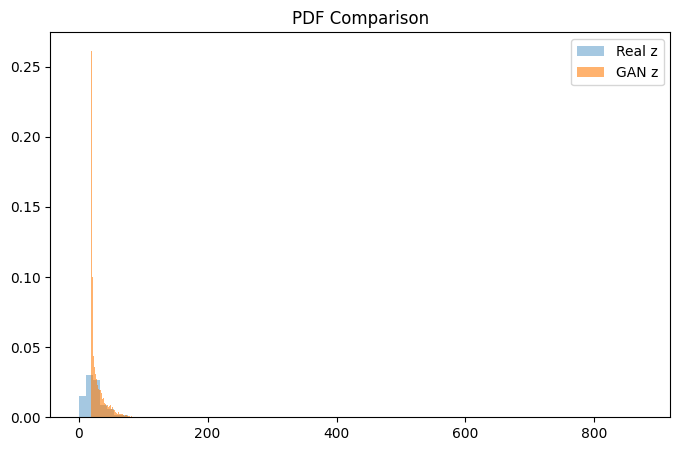

In [17]:
# PDF Approximation
# 1. Histogram PDF

plt.figure(figsize=(8,5))
plt.hist(z, bins=80, density=True, alpha=0.4, label="Real z")
plt.hist(gen_z, bins=80, density=True, alpha=0.6, label="GAN z")
plt.title("PDF Comparison")
plt.legend()
plt.show()


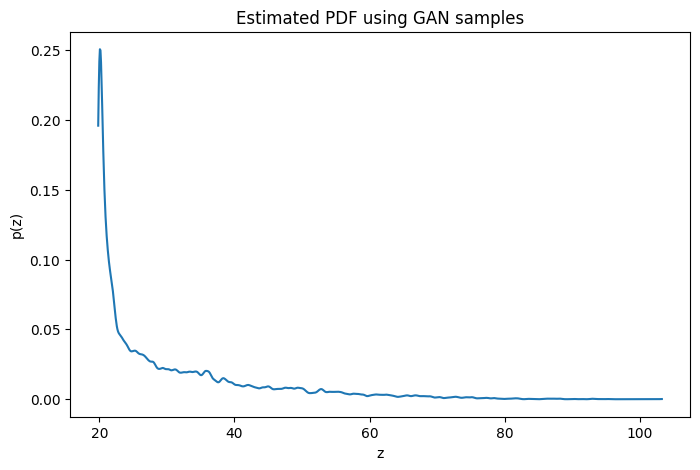

In [18]:
# OR 2. KDE PDF

gen_z = gen_z.reshape(-1, 1)

kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(gen_z)

z_range = np.linspace(gen_z.min(), gen_z.max(), 1000).reshape(-1,1)
log_dens = kde.score_samples(z_range)

plt.figure(figsize=(8,5))
plt.plot(z_range, np.exp(log_dens))
plt.title("Estimated PDF using GAN samples")
plt.xlabel("z")
plt.ylabel("p(z)")
plt.show()